In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/data/GitHub/NeuroPy'])  # Add path to NeuroPy repository here

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.io.minianio import MinianIO
from neuropy.io.dlcio import DLC
from neuropy.core.session import ProcessData
import neuropy.io.openephysio as oeio


In [2]:
dir_use = "/data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin"
sess = ProcessData(dir_use)
print(sess.recinfo)

filename: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Finn2_psilocybin_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



# Import miniscope data and timestamps
NOTE: this has not yet been implemented.

First, run the session through the minian pipeline and save your S, A, and C variables to numpy arrays in a "minian" folder somewhere in the session folder

Second, designate any *corrupted files* by creating a "corrupted_videos.csv" file in the folder where your timeStamps.csv file lives. List the index to each corrupted file separated by commas. Even if you have concatenated all your videos from different recordings together in minian this file you should still put this in the file for each recording with a corrupted file.

In [24]:
# Now, load in all the video timestamps and minian data.
sess.miniscope = MiniscopeIO(sess.basepath)
sess.miniscope.load_all_timestamps()
sess.minian = MinianIO(sess.basepath / "Miniscope_combined" / "minian")

Keeping 102335 good frames found in "good_frames_bool.npy" file


In [26]:
# Show rough timestamps for all
sess.minian.times.tail(30)

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
13344,13344,899037,0,2023-05-25 15:49:01.292
13345,13345,899104,0,2023-05-25 15:49:01.359
13346,13346,899171,0,2023-05-25 15:49:01.426
13347,13347,899239,0,2023-05-25 15:49:01.494
13348,13348,899306,0,2023-05-25 15:49:01.561
13349,13349,899374,0,2023-05-25 15:49:01.629
13350,13350,899441,0,2023-05-25 15:49:01.696
13351,13351,899508,0,2023-05-25 15:49:01.763
13352,13352,899576,0,2023-05-25 15:49:01.831
13353,13353,899644,0,2023-05-25 15:49:01.899


# Create sync_df DataFrame for all ephys recordings

In [3]:
sess.sync = oeio.create_sync_df(sess.basepath, sr_dat=sess.datfile.sampling_rate, sr_eeg=sess.eegfile.sampling_rate)
sess.sync

start time = 2023-05-25 11:29:42.819033-04:00
start time = 2023-05-25 12:07:50.764904-04:00
start time = 2023-05-25 13:10:53.348552-04:00
start time = 2023-05-25 14:01:56.921020-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-25 11:29:42.819033-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-25 11:58:16.901133-04:00,stop,51422463,1714.082100,2142602,1714.0816
2,1,2023-05-25 12:07:50.764904-04:00,start,51422464,1714.082133,2142603,1714.0824
3,1,2023-05-25 13:08:37.595804-04:00,stop,160827391,5360.913033,6701141,5360.9128
4,2,2023-05-25 13:10:53.348552-04:00,start,160827392,5360.913067,6701142,5360.9136
5,2,2023-05-25 14:00:12.102652-04:00,stop,249590015,8319.667167,10399583,8319.6664
6,3,2023-05-25 14:01:56.921020-04:00,start,249590016,8319.667200,10399584,8319.6672
7,3,2023-05-25 15:51:50.363120-04:00,stop,447393279,14913.109300,18641386,14913.1088


# Get TTLs to OE for synchronization

In [ ]:
from datetime import datetime
import os
tak1_file = "/run/media/nkinsky/Nat1/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.11.17 PM.tak"
tak2_file = "/run/media/nkinsky/Nat1/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.46.32 PM.tak"
(pd.Timestamp(datetime.fromtimestamp(os.path.getmtime(tak1_file))))

In [ ]:
# NRK note - check in code if timestamps between OE and optitrack match up well, otherwise chuck them and go by timestamps!

# Import DLC files

### Need to use combination of .tak creation time and nframes to get actual start time in microseconds for Finn2. Will vary for each animal!
Below has only second precision.

### IMPORTANT NOTE
pix2cm needs to be determined for each animal separately. The rest box is 35.6 cm x 30.5 cm.

In [41]:
sess.dlc = DLC(sess.basepath, pix2cm=0.133)

Using tracking file #0: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.11.17 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #1: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.46.32 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #2: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 02.02.15 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #3: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 02.30.20 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #4: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 03.03.27 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #5: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 

In [42]:
sess.dlc.get_timestamps()

No Optitrack csv file found at Take 2023-05-25 01.11.17 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 13:11:17
No Optitrack csv file found at Take 2023-05-25 01.46.32 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 13:46:32
No Optitrack csv file found at Take 2023-05-25 02.02.15 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 14:02:15
No Optitrack csv file found at Take 2023-05-25 02.30.20 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 14:30:20
No Optitrack csv file found at Take 2023-05-25 03.03.27 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferr

In [52]:
start_time_exact_df = pd.read_csv(sess.basepath / "inferred_start_time.csv", index_col=0)
start_time_exact_df["inferred_start_time"] = pd.to_datetime(start_time_exact_df["inferred_start_time"]).dt.tz_localize("America/Detroit")
start_time_exact_df

,file,mod_time,inferred_start_time
0,Take 2023-05-25 01.11.17 PM,2023-05-25 13:46:28.948677,2023-05-25 13:11:18.182010333-04:00
1,Take 2023-05-25 01.46.32 PM,2023-05-25 14:00:05.907641,2023-05-25 13:46:33.107641-04:00
2,Take 2023-05-25 02.02.15 PM,2023-05-25 14:30:12.290220,2023-05-25 14:02:15.823553333-04:00
3,Take 2023-05-25 02.30.20 PM,2023-05-25 15:03:18.019197,2023-05-25 14:30:21.119197-04:00
4,Take 2023-05-25 03.03.27 PM,2023-05-25 15:33:55.037206,2023-05-25 15:03:27.537206-04:00
5,Take 2023-05-25 03.34.01 PM,2023-05-25 15:51:40.527097,2023-05-25 15:34:02.293763667-04:00
6,Take 2023-05-25 11.30.40 AM,2023-05-25 11:30:56.922524,2023-05-25 11:30:40.755857333-04:00
7,Take 2023-05-25 11.31.11 AM,2023-05-25 11:34:05.077632,NaT
8,Take 2023-05-25 11.35.02 AM,2023-05-25 11:58:14.729469,2023-05-25 11:35:03.129469-04:00
9,Take 2023-05-25 12.08.16 PM,2023-05-25 12:08:20.407698,2023-05-25 12:08:16.607698-04:00


### Update timestamps to millisecond (microsecond?) precision.
Above imports files with only second precision.  In this case, we have used the final modification time of the Optitrack .tak file minus the number of frames divided by the frame rate to get the exact start time of each optitrack recording. These have been dumped into a "inferred_start_time.csv" file, which we read in and use to adjust each recording's start time below.

In [79]:
# Iterate through each movie and update timestamps for each
for idr, row in start_time_exact_df.iterrows():
    try:
        file_num = np.where([row.file in str(track_file) for track_file in sess.dlc.tracking_files])[0][0]
        start_delta = row["inferred_start_time"] - sess.dlc.timestamps.loc[sess.dlc.timestamps["File num"] == file_num, :]["Timestamps"].min()
        ts_orig = deepcopy(sess.dlc.timestamps.loc[sess.dlc.timestamps["File num"] == file_num, "Timestamps"])
        sess.dlc.timestamps.loc[sess.dlc.timestamps["File num"] == file_num, "Timestamps"] = ts_orig + start_delta
    except IndexError:
        print(f"No tracking file found for file '{row.file}'. Skipping")


No tracking file found for file 'Take 2023-05-25 11.31.11 AM'. Skipping


### Now plot position as a sanity check

<Axes: title={'center': 'Finn2: crown_middle'}, xlabel='lcutoff = 0.9'>

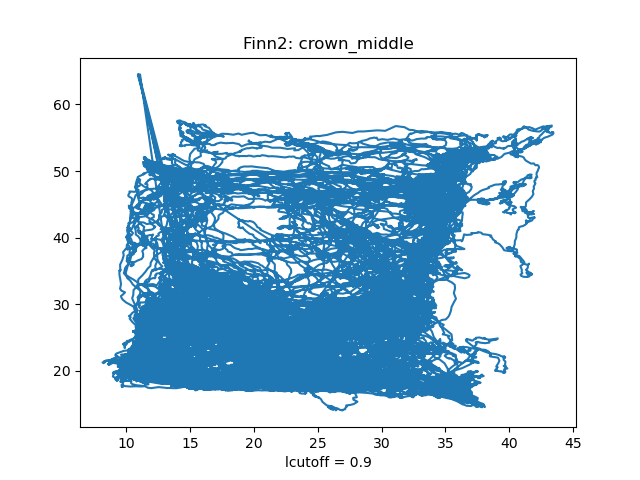

In [82]:
# Plot animal crown position for all points with confidence of 0.9 or more
_, ax = plt.subplots()
sess.dlc.plot2d(bodyparts="crown_middle", lcutoff=0.9, ax=ax)

### Plot speed after smoothing position data. Note artifactual jumps at each new recording.

get_speed not yet tested for optitrack data, use with caution
get_speed not yet tested for optitrack data, use with caution


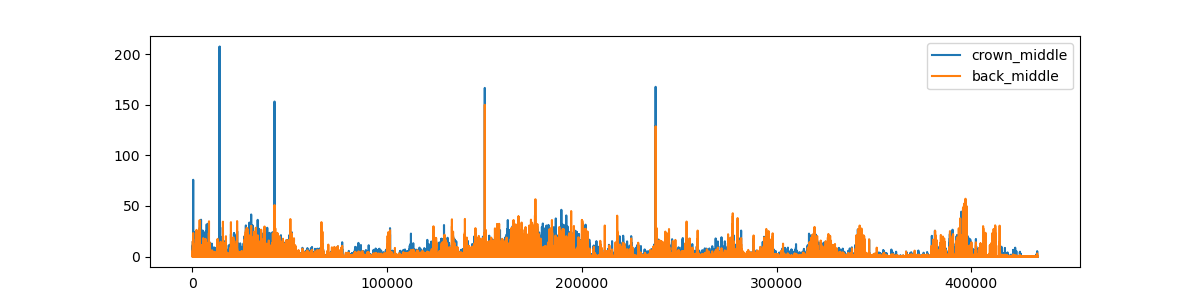

In [83]:
# Now plot speed data
%matplotlib widget
sess.dlc.smooth_pos()  # Smooth position before getting speed.
crown_speed = sess.dlc.get_speed(bodypart="crown_middle")
mid_back_speed = sess.dlc.get_speed(bodypart="back_middle")
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(crown_speed, label="crown_middle")
ax.plot(mid_back_speed, label="back_middle")
ax.legend()

### Finally interpolate all the times to eeg times so that your position data is referenced to the correct ephys time.

In [84]:
sync_sec = (sess.sync['Datetime'] - sess.sync['Datetime'][0]).dt.total_seconds()
dlc_sec_from_oe_start = (sess.dlc.timestamps["Timestamps"] - sess.sync['Datetime'][0]).dt.total_seconds()
eeg_timestamps = np.interp(dlc_sec_from_oe_start, sync_sec, sess.sync["eeg_time"].values)


In [85]:
good_bool = np.zeros_like(eeg_timestamps, dtype="bool")
for rec in sess.sync["Recording"].unique():
    rec_df = sess.sync[sess.sync["Recording"] == rec]
    bool_temp = (eeg_timestamps >= rec_df.loc[rec_df.Condition == "start", "eeg_time"].values[0]) & (eeg_timestamps <= rec_df.loc[rec_df.Condition == "stop", "eeg_time"].values[0])
    good_bool = good_bool | bool_temp

eeg_timestamps[~good_bool] = np.nan

(1700.0, 1800.0)

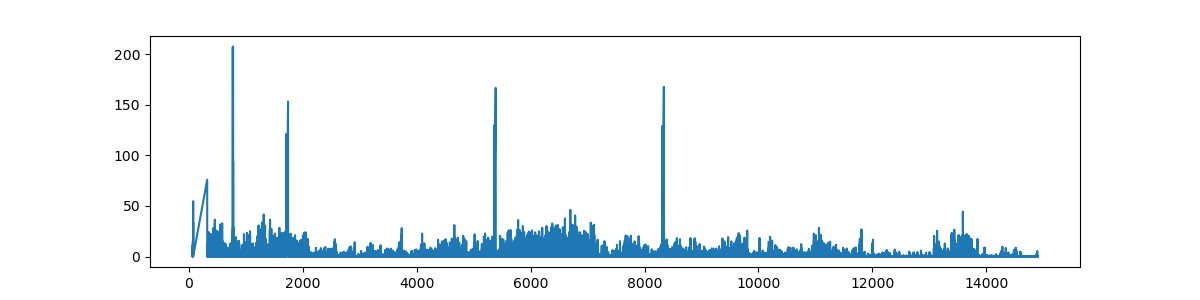

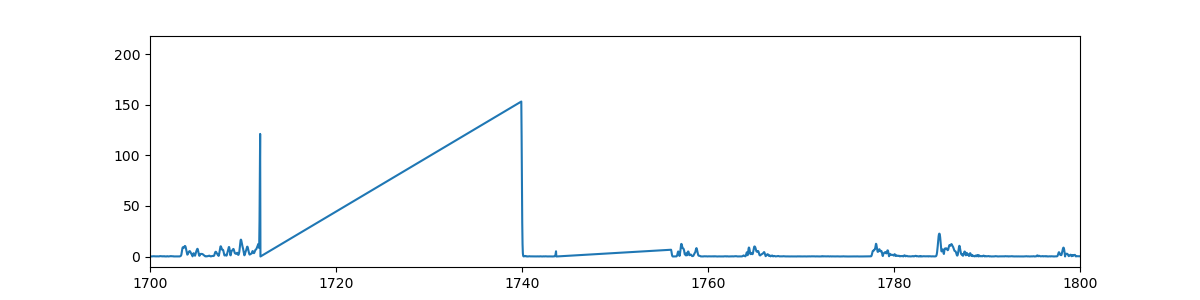

In [86]:
# Now plot again - should see gaps in speed where recording stops that should be ignored
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(eeg_timestamps, crown_speed)

_, ax = plt.subplots(figsize=(12, 3))
ax.plot(eeg_timestamps, crown_speed)
ax.set_xlim((1700, 1800))

# Plan for alignment
designate each recording session in `epochs`, then have an `align_by` flag that will either align by TTL or by timestamps or, in the case of oe and position, align by theta v speed.  Also, for some sessions I have an input from the miniscope to Intan that I can use.

Since some epochs will have a TTL at the start but not later on after a disconnect, you will need to either a) fake a "disconnect" event and only use the TTL if there is an off-on transition after the disconnect, or b) just search for the closet TTL PRIOR to each timestamp to figure out how to align it.  Function would look identify a range of times and then flag them as either "align_by_timestamps" or "align_by_TTL" or "align_by_theta" (position to oe only) or "MS_to_oe_TTL".

# Options for alignment

## 1) TTL - digital or analog?

## 2) Timestamps - currently not accurate enough

## 3) theta as a backup

# Read in DLC pos data and sync with Optitrack timestamps